In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
from joblib import Parallel, delayed



In [50]:
# Parameters
fs = 1000  # Sampling frequency
num_freqs = 2  # Number of dominant frequencies to find
param1_min, param1_max, param2_min, param2_max = 0.01, 0.1, 0.01, 0.1
param1_values = np.linspace(param1_min, param1_max, 20)
param2_values = np.linspace(param1_min, param1_max, 20)

# Generate or load your datasets
# datasets should be a list or array of shape (400,), each entry is a 1D NumPy array of data
random_numbers = np.random.uniform(size=1000)
data_set_1 = np.sin(random_numbers * 5) + np.sin(random_numbers * 10) + random_numbers * 0.1
data_set_2 = np.sin(random_numbers * 5) + np.sin(random_numbers * 8 + 2) + random_numbers * 0.5

time = np.arange(1000)

datasets = np.empty((len(param1_values), len(param2_values)), dtype=object)
for i, param1 in enumerate(param1_values):
    for j, param2 in enumerate(param2_values):
        datasets[i, j] = np.sin(2 * np.pi * param1 * time) + np.sin(2 * np.pi * param2 * time) #+ 0.05 * np.random.normal(size=1000)

In [53]:
def preprocess_data(data):
    data = np.nan_to_num(data)
    # Remove inactive periods
    threshold = np.std(data) * 0.1
    window_size = max(1, int(0.1 * len(data)))
    rolling_std = np.array([np.std(data[i:i+window_size]) for i in range(len(data) - window_size)])
    active_indices = np.where(rolling_std > threshold)[0]
    if len(active_indices) == 0:
        return np.array([])  # Return empty array if no active periods
    else:
        start = active_indices[0]
        end = active_indices[-1] + window_size
        return data[start:end]

def compute_psd(data, fs):
    if len(data) == 0:
        return np.array([]), np.array([])
    freqs, psd = welch(data, fs=fs, nperseg=min(256, len(data)))
    return freqs, psd

def find_dominant_frequencies(freqs, psd, num_freqs=2):
    if len(psd) == 0:
        return np.array([np.nan]*num_freqs), np.array([np.nan]*num_freqs)
    peaks, properties = find_peaks(psd, prominence=np.max(psd)*0.05)
    if len(peaks) == 0:
        return np.array([np.nan]*num_freqs), np.array([np.nan]*num_freqs)
    sorted_indices = np.argsort(psd[peaks])[::-1]
    dominant_freqs = freqs[peaks][sorted_indices][:num_freqs]
    dominant_powers = psd[peaks][sorted_indices][:num_freqs]
    # Pad with NaN if fewer than num_freqs frequencies found
    if len(dominant_freqs) < num_freqs:
        dominant_freqs = np.pad(dominant_freqs, (0, num_freqs - len(dominant_freqs)), constant_values=np.nan)
        dominant_powers = np.pad(dominant_powers, (0, num_freqs - len(dominant_powers)), constant_values=np.nan)
    return dominant_freqs, dominant_powers

def analyze_dataset(data):
    freqs, psd = compute_psd(data, fs)
    dominant_freqs, dominant_powers = find_dominant_frequencies(freqs, psd, num_freqs)
    return dominant_freqs, dominant_powers

# Flatten the datasets into a 1D list if necessary
datasets_flat = datasets.flatten()

# Analyze all datasets in parallel
results = Parallel(n_jobs=-1)(delayed(analyze_dataset)(data) for data in datasets_flat)

# Reshape results back to 20x20 grid
dominant_freqs_array = np.array([res[0] for res in results]).reshape(20, 20, num_freqs)
dominant_powers_array = np.array([res[1] for res in results]).reshape(20, 20, num_freqs)



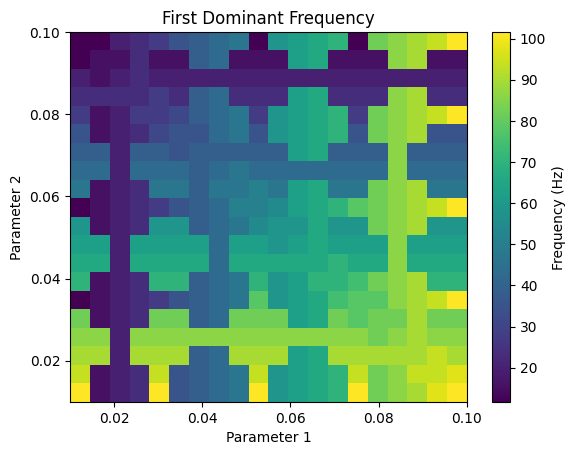

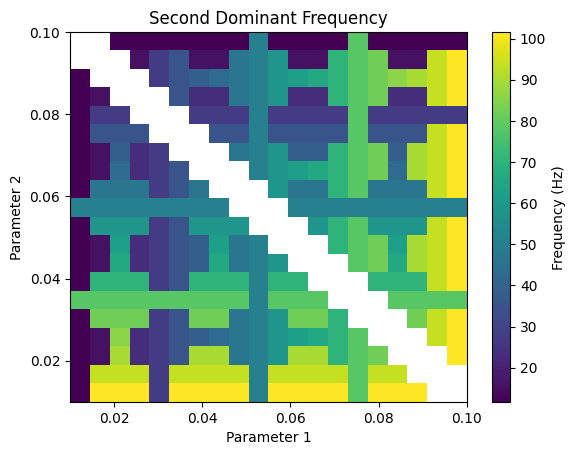

In [54]:
# Visualization
plt.imshow(dominant_freqs_array[:, :, 0], extent=[param1_min, param1_max, param2_min, param2_max], aspect='auto')
plt.colorbar(label='Frequency (Hz)')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title('First Dominant Frequency')
plt.show()

plt.imshow(dominant_freqs_array[:, :, 1], extent=[param1_min, param1_max, param2_min, param2_max], aspect='auto')
plt.colorbar(label='Frequency (Hz)')
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title('Second Dominant Frequency')
plt.show()